In [1]:
import os
os.chdir("../../../src")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from data import PolygonSentenceReader, Polygon, EOS_TOKEN
from modules import NLLLoss, ELBOLoss, MLP
from neural_process.models.np import CNP, LNP
from neural_process.models.attnnp import AttnCNP, AttnLNP
from transformer.models import TransformerDecoder
from utils import plot_polygon

import datetime
from functools import partial
from math import fabs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import torch
import torch.nn as nn
from torch.distributions.kl import kl_divergence

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tf params
x_dim = 1
y_dim = 1
r_dim = 128

# NP params
BATCH_SIZE = 128
MAX_CONTEXT_POINTS = 15
MIN_SIDES = 3
MAX_SIDES = 8
x_size = 5 + 4 * 12
y_size = x_size
torch.manual_seed(0)

CNPDecoder = partial(
    MLP,
    n_hidden_layers=6,
    hidden_size=320,
    dropout=0.2,
    is_res=True,
)
CNPEncoder = partial(
    MLP,
    n_hidden_layers=8,
    hidden_size=320,
    dropout=0.2,
    is_res=True,
)

ANPEncoder = partial(
    MLP,
    n_hidden_layers=2,
    hidden_size=224,
    dropout=0.2,
    is_res=True,
)

ANPDecoder = partial(
    MLP,
    n_hidden_layers=3,
    hidden_size=224,
    dropout=0.2,
    is_res=False,
)

ANPLatentEncoder = partial(
    MLP,
    n_hidden_layers=4,
    hidden_size=224,
    dropout=0.2,
    is_res=True,
)

# CNP
cnp_model = CNP(x_dim=x_size, y_dim=y_size, r_dim=320, Decoder=CNPDecoder, Encoder=CNPEncoder)
cnp_model.load_state_dict(torch.load("../models/polygon/np/masked_completion_task/CNP.pt"))
cnp_model.eval()
cnp_model.to(device)
total_params = sum(p.numel() for p in cnp_model.parameters())
print(f"CNP Total parameters: {total_params:,}")

# NP
np_model = LNP(x_dim=x_size, y_dim=y_size, r_dim=256, n_z_train=10, n_z_test=10)
np_model.load_state_dict(torch.load("../models/polygon/np/masked_completion_task/LNP.pt"))
np_model.eval()
np_model.to(device)
total_params = sum(p.numel() for p in np_model.parameters())
print(f"NP Total parameters: {total_params:,}")

# ANP
anp_model = AttnLNP(
    x_dim=x_size,
    y_dim=y_size,
    r_dim=224,
    attention_type="multihead",
    n_z_train=10,
    n_z_test=10,
    Encoder=ANPEncoder,
    LatentEncoder=ANPLatentEncoder,
    Decoder=ANPDecoder,
)
anp_model.load_state_dict(torch.load("../models/polygon/np/masked_completion_task/AttnLNP.pt"))
anp_model.eval()
anp_model.to(device)
total_params = sum(p.numel() for p in anp_model.parameters())
print(f"ANP Total parameters: {total_params:,}")

# Reconstruct the Transformer model and load the trained checkpoint
tf_model = TransformerDecoder(x_dim, y_dim, r_dim=r_dim, decoder_layers=8, decoder_heads=8)
checkpoint_path = f"../final_tf_model_1586561_params.pt"
checkpoint = torch.load(checkpoint_path, map_location=device)
tf_model.load_state_dict(checkpoint['model_state_dict'])
total_params = sum(p.numel() for p in tf_model.parameters())
print(f"TF Total parameters: {total_params:,}")
tf_model.eval()
tf_model.to(device)

tf_explicit_model = TransformerDecoder(x_dim, y_dim, r_dim=r_dim, decoder_layers=8, decoder_heads=8)
checkpoint_path = f"../final_tf_mask_model_1586561_params.pt"
checkpoint = torch.load(checkpoint_path, map_location=device)
tf_explicit_model.load_state_dict(checkpoint['model_state_dict'])
total_params = sum(p.numel() for p in tf_explicit_model.parameters())
print(f"FSTF Total parameters: {total_params:,}")
tf_explicit_model.eval()
tf_explicit_model.to(device)

CNP Total parameters: 1,532,266
NP Total parameters: 1,524,586
ANP Total parameters: 1,548,394
TF Total parameters: 1,586,561
FSTF Total parameters: 1,586,561


/vol/bitbucket/ls1221/fyp/fypenv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


TransformerDecoder(
  (project_r): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): ReLU()
  )
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
)

In [4]:
def evaluate_mean_baseline_masked_completion_on_batch(
    tgt_y, ctx_y, context_masks, max_num_sides, type=None
):
    """
    Baseline that always predicts the per-dimension mean of the *true*
    target-vector across the batch.
    """
    # ctx_y:   [B, N_ctx, D_out]
    # tgt_y:   [B, N_tgt, D_out]
    # context_masks: [B, 1, N_tgt]  (we only ever mask the final time‐step, so N_tgt==1)
    true   = tgt_y[:, -1, :]                         # [B, D_out]
    masks  = context_masks.squeeze(1).to(torch.bool) # [B, D_out]
    B, D    = true.shape

    all_errs           = []
    per_example_mae    = []
    per_example_sumerr = []

    if type == 'angle':
        baseline = (ctx_y[:, 0, 0] * max_num_sides - 2) / (ctx_y[:, 0, 0] * max_num_sides)
        baseline = baseline.unsqueeze(1).expand(-1, D)
    elif type == 'length':
        baseline = torch.sin(torch.pi / (ctx_y[:, 0, 0] * max_num_sides))
        baseline = baseline.unsqueeze(1).expand(-1, D)
    else: 
        # compute the “batch mean” for each dimension
        baseline = ctx_y.mean(dim=1)   # [B, D_out]

    for i in range(B):
        masked_idxs = masks[i].nonzero(as_tuple=False).flatten().tolist()
        if not masked_idxs:
            per_example_mae.append(0.0)
            per_example_sumerr.append(0.0)
            continue

        p_vals = [baseline[i, j].item() for j in masked_idxs]
        t_vals = [true[i, j].item() for j in masked_idxs]

        errs = [abs(p - t) for p, t in zip(p_vals, t_vals)]
        all_errs.extend(errs)
        per_example_mae.append(sum(errs) / len(errs))
        per_example_sumerr.append(abs(sum(p_vals) - sum(t_vals)))

    if not all_errs:
        return 0.0, 0.0, 0.0

    avg_abs_err    = sum(all_errs) / len(all_errs)
    avg_masked_mae = sum(per_example_mae) / len(per_example_mae)
    avg_sum_err    = sum(per_example_sumerr) / len(per_example_sumerr)

    return avg_abs_err, avg_masked_mae, avg_sum_err

def evaluate_neural_process_masked_completion_on_batch(
    model, ctx_x, ctx_y, tgt_x, tgt_y,
    context_masks, max_seq_len, device
):
    """
    Few-shot masked completion with a Neural Process.
    """
    model.eval()
    with torch.no_grad():
        p_y_dist, z, q_zc, q_zct = model(
            ctx_x, ctx_y, tgt_x, None
        )
        mean_z = p_y_dist.mean.mean(dim=0)
        pred_y = mean_z[:, -1, :]

    true = tgt_y[:, -1, :]
    masks = context_masks.squeeze(1).to(torch.bool)

    B = pred_y.shape[0]
    all_errs = []
    per_example_mae = []
    per_example_sum_err = []

    for i in range(B):
        # indices of masked positions in this example
        masked_idxs = masks[i].nonzero(as_tuple=False).flatten().tolist()

        # if nothing was masked, skip
        if not masked_idxs:
            per_example_mae.append(0.0)
            per_example_sum_err.append(0.0)
            continue

        # gather predictions & truths
        p_vals = [pred_y[i, j].item() for j in masked_idxs]
        t_vals = [true[i, j].item()  for j in masked_idxs]

        # per-token absolute errors
        errs = [abs(p - t) for p, t in zip(p_vals, t_vals)]
        all_errs.extend(errs)

        # per-example MAE
        per_example_mae.append(sum(errs) / len(errs))

        # per-example sum error
        per_example_sum_err.append(abs(sum(p_vals) - sum(t_vals)))

    if len(all_errs) == 0:
        return 0.0, 0.0, 0.0

    avg_abs_err = sum(all_errs) / len(all_errs)
    avg_angle_mae = sum(per_example_mae) / len(per_example_mae)
    avg_angle_sum_err= sum(per_example_sum_err) / len(per_example_sum_err)

    return (
        avg_abs_err,
        avg_angle_mae,
        avg_angle_sum_err
    )

def evaluate_transformer_masked_completion_on_batch(
    model, ctx_x, ctx_y, tgt_x, tgt_y,
    context_masks, max_seq_len, device
):
    """
    Few-shot masked completion with a Transformer.
    """
    B, C, _ = ctx_x.shape
    true = tgt_y[:, -1, :]
    masks = context_masks.squeeze(1).bool()

    all_errs = []
    per_example_mae = []
    per_example_sum_err = []

    masks = context_masks.squeeze(1).to(torch.bool)

    model.eval()
    with torch.no_grad():
        for i in range(B):
            # Build prompt
            prompt = []
            for j in range(C):
                toks = ctx_x[i,j].tolist()
                while toks and toks[-1]==0.0: toks.pop()
                prompt += toks
                toks = ctx_y[i,j].tolist()
                while toks and toks[-1]==0.0: toks.pop()
                prompt += toks

            partial = tgt_x[i,-1].tolist()
            while partial and partial[-1]==0.0: partial.pop()
            prompt += partial
            L_tgt = len(partial)

            # Autoregressive loop
            generated = prompt.copy()
            for _ in range(L_tgt):
                if len(generated) > max_seq_len:
                    generated = generated[-max_seq_len:]
                inp = (
                    torch.tensor(generated, device=device)
                         .unsqueeze(1).unsqueeze(-1)
                )  # [seq_len, 1, 1]
                logits = model(inp)    # → same shape
                nxt = logits[-1, 0, 0].item()
                generated.append(nxt)

            # Extract the newly generated segment
            pred_seq = generated[-L_tgt:] # length tgt_y_len

            # Compute errors only where masked=True
            masked_idxs = masks[i, :L_tgt].nonzero(as_tuple=False).flatten().tolist()

            if not masked_idxs:
                per_example_mae.append(0.0)
                per_example_sum_err.append(0.0)
                continue

            p_vals = [pred_seq[j] for j in masked_idxs]
            t_vals = [true[i, j].item() for j in masked_idxs]

            errs = [abs(p - t) for p, t in zip(p_vals, t_vals)]
            all_errs.extend(errs)
            per_example_mae.append(sum(errs) / len(errs))
            per_example_sum_err.append(abs(sum(p_vals) - sum(t_vals)))

    if len(all_errs) == 0:
        return 0.0, 0.0, 0.0

    avg_abs_err = sum(all_errs) / len(all_errs)
    avg_masked_mae = sum(per_example_mae) / len(per_example_mae)
    avg_masked_sum_err = sum(per_example_sum_err) / len(per_example_sum_err)

    return (
        avg_abs_err,
        avg_masked_mae,
        avg_masked_sum_err,
    )

In [5]:
def compare_models_shared_data(reader, cnp_model, np_model, anp_model, tf_model, tf_explicit_model, tf_max_seq_len, context_sizes, sides, runs_per_size, max_num_sides, mask_cfg, device):
    """
    Compare NP and Transformer on same sampled tasks.
    """
    results = {
        'Baseline': {},
        'CNP': {},
        'LNP': {},
        'ANP': {},
        # 'TF': {},
        # 'FSTF': {},
    }

    results_std = {
        'Baseline': {},
        'CNP': {},
        'LNP': {},
        'ANP': {},
        # 'TF': {},
        # 'FSTF': {},
    }

    cnp_model.to(device).eval()
    np_model.to(device).eval()
    anp_model.to(device).eval()
    tf_model.to(device).eval()
    tf_explicit_model.to(device).eval()

    for c in context_sizes:
        errs_baseline, maes_baseline, sums_baseline = [], [], []
        errs_cnp, maes_cnp, sums_cnp = [], [], []
        errs_np, maes_np, sums_np = [], [], []
        errs_anp, maes_anp, sums_anp = [], [], []
        errs_tf, maes_tf, sums_tf = [], [], []
        errs_fstf, maes_fstf, sums_fstf = [], [], []

        for _ in range(runs_per_size):
            # Generate a single batch of tasks (shared data)
            (ctx_x, ctx_y, tgt_x, tgt_y, _,
             _, max_seq_len, _, _, context_masks) = reader.generate_polygon_batch_few_shot_masked_completion_task(c, sides, mask_cfg)

            ctx_x, ctx_y = ctx_x.to(device), ctx_y.to(device)
            tgt_x, tgt_y = tgt_x.to(device), tgt_y.to(device)

            # -- Baseline evaluation --
            avg_baseline, mae_baseline, sum_baseline = evaluate_mean_baseline_masked_completion_on_batch(
                tgt_y, ctx_y, context_masks, max_num_sides, type=mask_cfg['type']
            )
            errs_baseline.append(avg_baseline); maes_baseline.append(mae_baseline); sums_baseline.append(sum_baseline)

            # -- Conditional Neural Process evaluation --
            avg_cnp, mae_cnp, sum_cnp = evaluate_neural_process_masked_completion_on_batch(
                cnp_model, ctx_x, ctx_y, tgt_x, tgt_y, context_masks, max_seq_len, device
            )
            errs_cnp.append(avg_cnp); maes_cnp.append(mae_cnp); sums_cnp.append(sum_cnp)

            # -- Latent Neural Process evaluation --
            avg_np, mae_np, sum_np = evaluate_neural_process_masked_completion_on_batch(
                np_model, ctx_x, ctx_y, tgt_x, tgt_y, context_masks, max_seq_len, device
            )
            errs_np.append(avg_np); maes_np.append(mae_np); sums_np.append(sum_np)

            # -- Attentive Neural Process evaluation --
            avg_anp, mae_anp, sum_anp = evaluate_neural_process_masked_completion_on_batch(
                anp_model, ctx_x, ctx_y, tgt_x, tgt_y, context_masks, max_seq_len, device
            )
            errs_anp.append(avg_anp); maes_anp.append(mae_anp); sums_anp.append(sum_anp)

            # -- Transformer evaluation --
            # avg_tf, mae_tf, sum_tf = evaluate_transformer_masked_completion_on_batch(
            #     tf_model, ctx_x, ctx_y, tgt_x, tgt_y, context_masks, tf_max_seq_len, device
            # )
            # errs_tf.append(avg_tf); maes_tf.append(mae_tf); sums_tf.append(sum_tf)

            # # -- Transformer with explicit context evaluation --
            # avg_fstf, mae_fstf, sum_fstf = evaluate_transformer_masked_completion_on_batch(
            #     tf_explicit_model, ctx_x, ctx_y, tgt_x, tgt_y, context_masks, tf_max_seq_len, device
            # )
            # errs_fstf.append(avg_fstf); maes_fstf.append(mae_fstf); sums_fstf.append(sum_fstf)

        results['Baseline'][c] = {
            'abs_err': np.mean(errs_baseline),
            'masked_mae': np.mean(maes_baseline),
            'sum_err': np.mean(sums_baseline),
        }
        results['CNP'][c] = {
            'abs_err': np.mean(errs_cnp),
            'masked_mae': np.mean(maes_cnp),
            'sum_err': np.mean(sums_cnp),
        }
        results['LNP'][c] = {
            'abs_err': np.mean(errs_np),
            'masked_mae': np.mean(maes_np),
            'sum_err': np.mean(sums_np),
        }
        results['ANP'][c] = {
            'abs_err': np.mean(errs_anp),
            'masked_mae': np.mean(maes_anp),
            'sum_err': np.mean(sums_anp),
        }
        # results['TF'][c] = {
        #     'abs_err': np.mean(errs_tf),
        #     'masked_mae': np.mean(maes_tf),
        #     'sum_err': np.mean(sums_tf),
        # }
        # results['FSTF'][c] = {
        #     'abs_err': np.mean(errs_fstf),
        #     'masked_mae': np.mean(maes_fstf),
        #     'sum_err': np.mean(sums_fstf),
        # }
        
        results_std['Baseline'][c] = {
            'abs_err': np.std(errs_baseline),
            'masked_mae': np.std(maes_baseline),
            'sum_err': np.std(sums_baseline),
        }
        results_std['CNP'][c] = {
            'abs_err': np.std(errs_cnp),
            'masked_mae': np.std(maes_cnp),
            'sum_err': np.std(sums_cnp),
        }
        results_std['LNP'][c] = {
            'abs_err': np.std(errs_np),
            'masked_mae': np.std(maes_np),
            'sum_err': np.std(sums_np),
        }
        results_std['ANP'][c] = {
            'abs_err': np.std(errs_anp),
            'masked_mae': np.std(maes_anp),
            'sum_err': np.std(sums_anp),
        }
        # results_std['TF'][c] = {
        #     'abs_err': np.std(errs_tf),
        #     'masked_mae': np.std(maes_tf),
        #     'sum_err': np.std(sums_tf),
        # }
        # results_std['FSTF'][c] = {
        #     'abs_err': np.std(errs_fstf),
        #     'masked_mae': np.std(maes_fstf),
        #     'sum_err': np.std(sums_fstf),
        # }

    return results, results_std


# In distribution


############################################################
Testing mask: {'type': 'length', 'p': 0.4}
############################################################ 

→ 3-sided polygons
→ 4-sided polygons
→ 5-sided polygons
→ 8-sided polygons
→ 9-sided polygons
→ 10-sided polygons


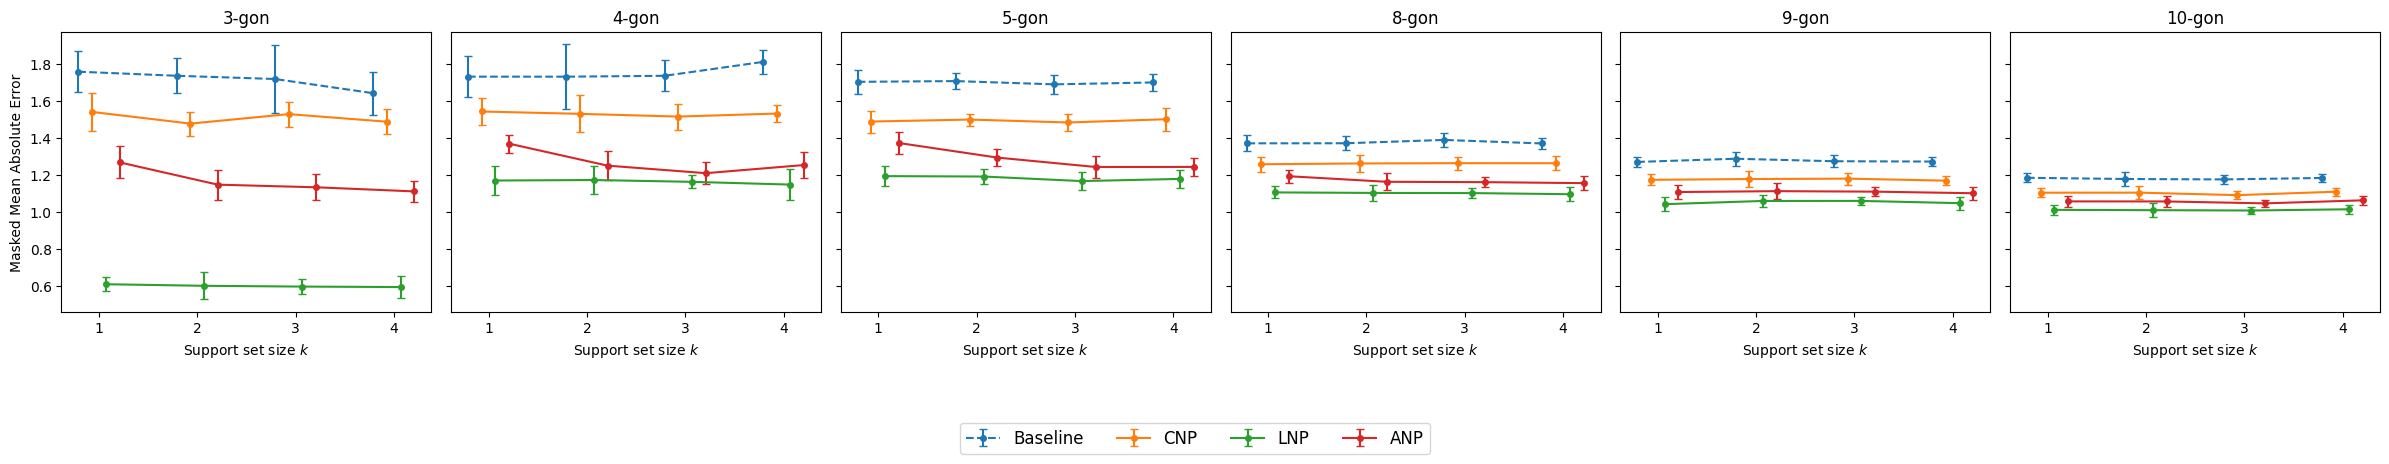


############################################################
Testing mask: {'type': 'angle', 'p': 0.4}
############################################################ 

→ 3-sided polygons
→ 4-sided polygons
→ 5-sided polygons
→ 8-sided polygons
→ 9-sided polygons
→ 10-sided polygons


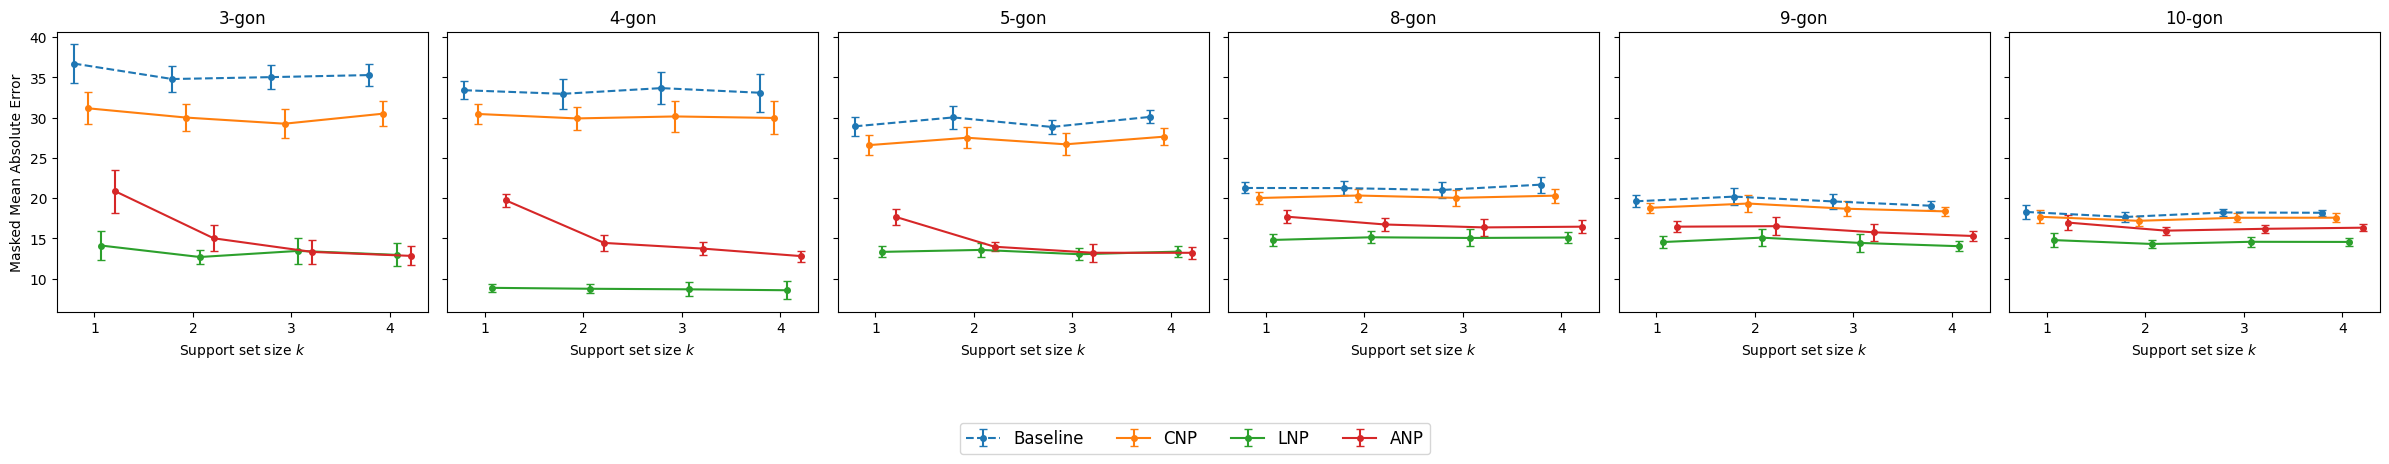


############################################################
Testing mask: {'type': 'vertex', 'p': 0.2}
############################################################ 

→ 3-sided polygons
→ 4-sided polygons
→ 5-sided polygons
→ 8-sided polygons
→ 9-sided polygons
→ 10-sided polygons


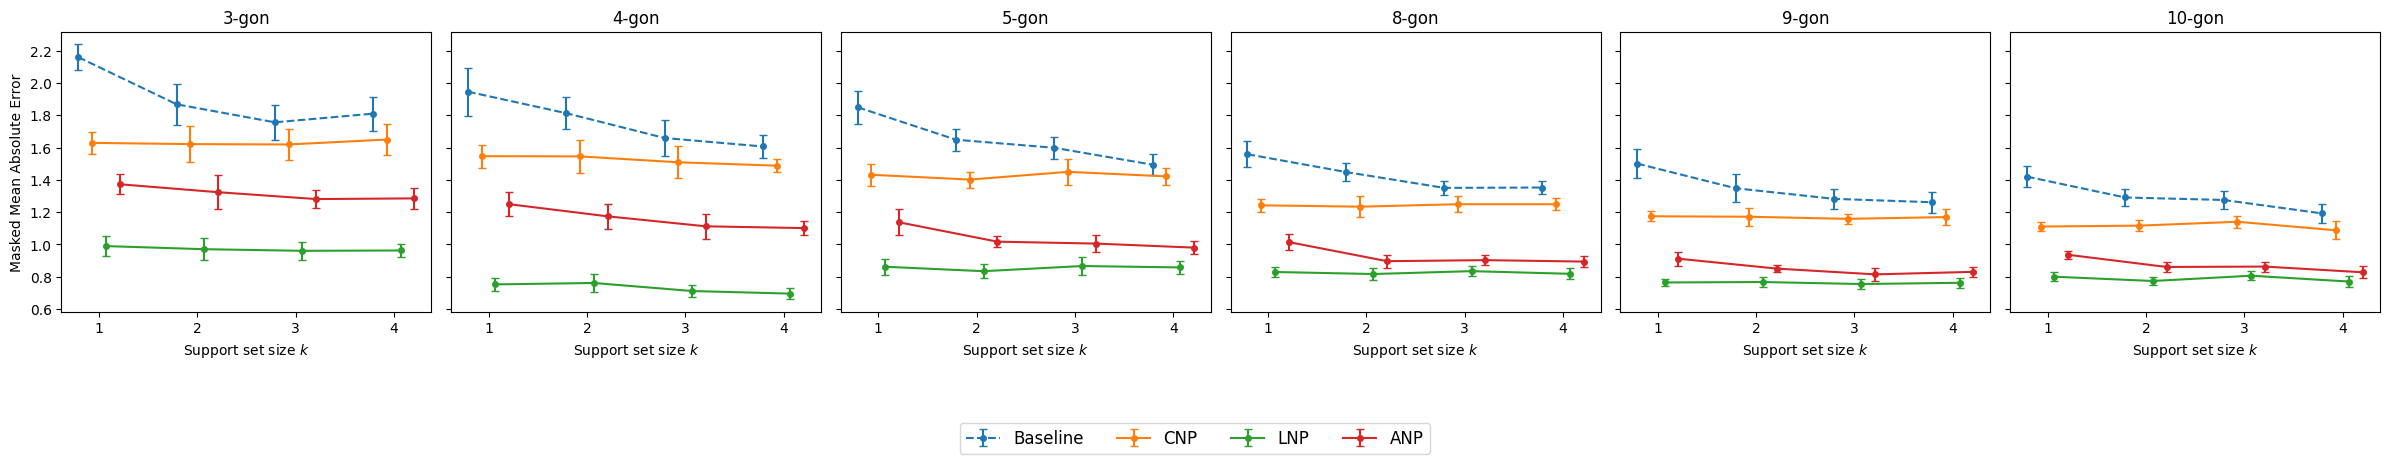


############################################################
Testing mask: {'type': 'random', 'p': 0.15}
############################################################ 

→ 3-sided polygons
→ 4-sided polygons
→ 5-sided polygons
→ 8-sided polygons
→ 9-sided polygons
→ 10-sided polygons


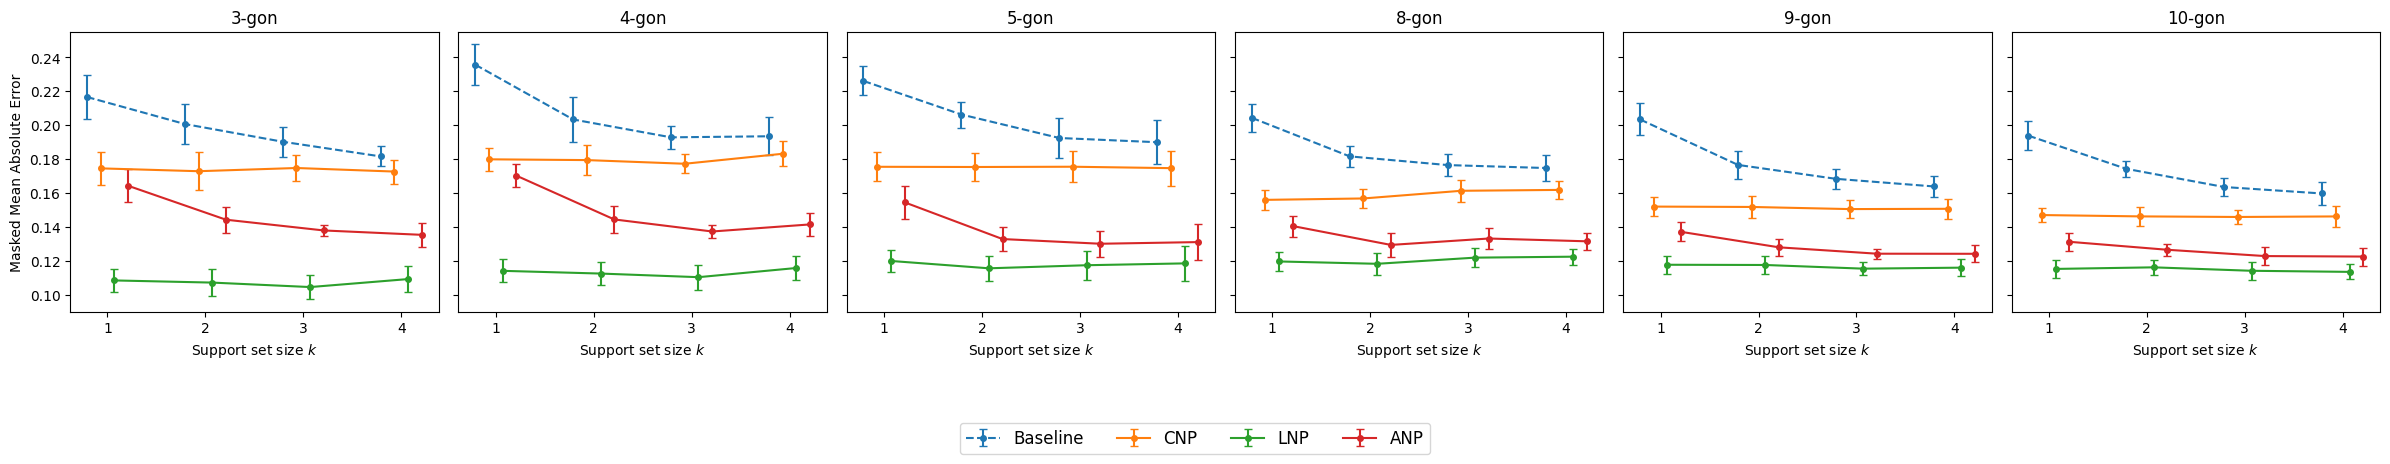

Saved consolidated results to ../notebooks/polygon/masked_completion_task/results/in_distribution_results.csv


In [9]:
sides = [3, 4, 5, 8, 9, 10] # [3,4,5,8,9,10] 
context_sizes = list(range(1, 5)) # 1-4
runs_per_size = 10
tf_max_seq_len = 512
radius = 3
center = (5,5)

mask_configs = [
    {"type": "length", "p": 0.4},        # only mask side‐length tokens
    {"type": "angle", "p": 0.4},         # only mask angle tokens
    {"type": "vertex", "p": 0.2},  # only mask vertex tokens
    {"type": "random", "p": 0.15},
]

all_rows = []

for mask_cfg in mask_configs:
    print("\n" + "#"*60)
    print("Testing mask:", mask_cfg)
    print("#"*60, "\n")

    results = {s : {} for s in sides}

    for s in sides:
        print(f"→ {s}-sided polygons")
        # make a reader that only generates s-sided polygons, with deterministic masks
        polygon_reader_eval = PolygonSentenceReader(
            batch_size=128,
            max_num_context=MAX_CONTEXT_POINTS,
            max_seq_len=x_size,
            min_num_sides=3,
            max_num_sides=12,
            testing=True,
        )

        masked_mae, masked_mae_std = compare_models_shared_data(
            reader=polygon_reader_eval,
            cnp_model=cnp_model,
            np_model=np_model,
            anp_model=anp_model,
            tf_model=tf_model,
            tf_explicit_model=tf_explicit_model,
            tf_max_seq_len=tf_max_seq_len,
            context_sizes=context_sizes,
            sides=s,
            runs_per_size=runs_per_size,
            max_num_sides=12,
            mask_cfg=mask_cfg,
            device=device
        )

        results[s]["masked_mae"], results[s]["masked_mae_std"] = masked_mae, masked_mae_std

        # for model_name in ['Baseline', 'CNP','LNP','ANP','TF', 'FSTF']:
        for model_name in ['Baseline', 'CNP','LNP','ANP']:
            for k in context_sizes:
                m  = results[s]['masked_mae'][model_name][k]["masked_mae"]
                sd = results[s]['masked_mae_std'][ model_name][k]["masked_mae"]
                all_rows.append({
                    'mask_type':   mask_cfg['type'],
                    'mask_p':      mask_cfg.get('p', '0'),
                    'side_count':  s,
                    'model':       model_name,
                    'k':           k,
                    'mae_mean':    m,
                    'mae_std':     sd
                })

    plot_configs = [
        ('abs_err',    'Average Absolute Error'),
        ('masked_mae', 'Masked MAE'),
        ('sum_err',    'Masked Sum Error'),
    ]
    model_plotting = [
        ('Baseline', '--o'),
        ('CNP', '-o'),
        ('LNP',  '-o'),
        ('ANP', '-o'),
        # ('TF',  '-o'),
        # ('FSTF', '-o'),
    ]

    ncols = len(sides)
    fig, axes = plt.subplots(
        1, ncols,
        sharey=True,
        figsize=(4 * ncols, 4)
    )

    M = len(model_plotting)
    total_width = 0.42

    # per‐method offset = evenly spaced between –total_width/2 and +total_width/2
    offsets = np.linspace(-total_width/2, total_width/2, M)

    for ax, s in zip(axes, sides):
        for (model_name, marker), dx in zip(model_plotting, offsets):
            ys   = [results[s]['masked_mae'][model_name][k]["masked_mae"] for k in context_sizes]
            yerr = [results[s]['masked_mae_std'][model_name][k]["masked_mae"] for k in context_sizes]
            if mask_cfg['type'] in ('length', 'vertex'):
                ys = Polygon._unnormalise_lengths(ys, radius)
                yerr = Polygon._unnormalise_lengths(yerr, radius)
            if mask_cfg['type'] == 'angle':
                ys = Polygon._unnormalise_angles(ys)
                yerr = Polygon._unnormalise_angles(yerr)
            ax.errorbar(
                context_sizes+dx, 
                ys,
                yerr=yerr,
                fmt=marker,
                capsize=3,
                markersize=4,
                linewidth=1.5,
                label=model_name,
            )
        ax.set_title(f"{s}-gon")
        ax.set_xlabel("Support set size $k$")
        ax.set_xticks(context_sizes)
        ax.set_xticklabels(context_sizes)

    axes[0].set_ylabel("Masked Mean Absolute Error")

    # one legend for all
    fig.legend(
        [m for m,_ in model_plotting],
        loc='upper center',
        ncol=len(model_plotting),
        bbox_to_anchor=(0.5, -0.05),
        fontsize=12,
    )

    fig.tight_layout(rect=[0,0.05,1,1])
    if mask_cfg['type'] == "random":
        fig.savefig(f"../notebooks/polygon/masked_completion_task/figures/in_distribution_{mask_cfg['type']}{mask_cfg.get('p', '')}.pdf",
                    bbox_inches='tight',)
    else:
        fig.savefig(f"../notebooks/polygon/masked_completion_task/figures/in_distribution_{mask_cfg['type']}{mask_cfg.get('p', '')}.pdf")
    plt.show()

df = pd.DataFrame(all_rows)
df.to_csv('../notebooks/polygon/masked_completion_task/results/in_distribution_results.csv', index=False)
print(f"Saved consolidated results to ../notebooks/polygon/masked_completion_task/results/in_distribution_results.csv")


# Near Distribution -> Side lengths 6-7 and 11-12

In [ ]:
sides = range(9, 13)
context_sizes = list(range(1, 4))
runs_per_size = 10
tf_max_seq_len = 512

mask_configs = [
    {"type": "length", "p": 0.2},
    {"type": "angle", "p": 0.2},
    {"type": "vertex", "p": 0.2},  # only mask vertex tokens
    {"type": "random", "p": 0.15},
]

all_rows = []

for mask_cfg in mask_configs:
    print("\n" + "#"*60)
    print("Testing mask:", mask_cfg)
    print("#"*60, "\n")

    results = {s : {} for s in sides}

    for s in sides:
        print(f"→ {s}-sided polygons")
        # make a reader that only generates s-sided polygons, with deterministic masks
        polygon_reader_eval = PolygonSentenceReader(
            batch_size=128,
            max_num_context=MAX_CONTEXT_POINTS,
            max_seq_len=x_size,
            min_num_sides=s,
            max_num_sides=s,
            testing=True,
        )

        masked_mae, masked_mae_std = compare_models_shared_data(
            reader=polygon_reader_eval,
            cnp_model=cnp_model,
            np_model=np_model,
            anp_model=anp_model,
            tf_model=tf_model,
            tf_max_seq_len=tf_max_seq_len,
            context_sizes=context_sizes,
            runs_per_size=runs_per_size,
            mask_cfg=mask_cfg,
            device=device
        )

        results[s]["masked_mae"], results[s]["masked_mae_std"] = masked_mae, masked_mae_std

        for model_name in ['CNP','LNP','ANP','TF', 'FSTF']:
            for k in context_sizes:
                m  = results[s]['masked_mae'][model_name][k]["masked_mae"]
                sd = results[s]['masked_mae_std'][ model_name][k]["masked_mae"]
                all_rows.append({
                    'mask_type':   mask_cfg['type'],
                    'mask_p':      mask_cfg.get('p', '0'),
                    'side_count':  s,
                    'model':       model_name,
                    'k':           k,
                    'mae_mean':    m,
                    'mae_std':     sd
                })

    plot_configs = [
        ('abs_err',    'Average Absolute Error'),
        ('masked_mae', 'Masked MAE'),
        ('sum_err',    'Masked Sum Error'),
    ]
    model_plotting = [
        ('Baseline', '-o'),
        ('CNP', '-o'),
        ('LNP',  '-o'),
        ('ANP', '-o'),
        ('TF',  '-o'),
        ('FSTF', '-o'),
    ]

    ncols = len(sides)
    fig, axes = plt.subplots(
        1, ncols,
        sharey=True,
        figsize=(4 * ncols, 4)
    )

    M = len(model_plotting)
    total_width = 0.42

    # per‐method offset = evenly spaced between –total_width/2 and +total_width/2
    offsets = np.linspace(-total_width/2, total_width/2, M)

    for ax, s in zip(axes, sides):
        for (model_name, marker), dx in zip(model_plotting, offsets):
            ys   = [results[s]['masked_mae'][model_name][k]["masked_mae"] for k in context_sizes]
            yerr = [results[s]['masked_mae_std'][model_name][k]["masked_mae"] for k in context_sizes]
            ax.errorbar(
                context_sizes+dx, 
                ys,
                yerr=yerr,
                fmt=marker,
                capsize=3,
                markersize=4,
                linewidth=1.5,
                label=model_name,
            )
        ax.set_title(f"{s}-gon")
        ax.set_xlabel("Support set size $k$")
        ax.set_xticks(context_sizes)
        ax.set_xticklabels(context_sizes)

    axes[0].set_ylabel("Masked Mean Absolute Error")

    # one legend for all
    fig.legend(
        [m for m,_ in model_plotting],
        loc='upper center',
        ncol=len(model_plotting),
        bbox_to_anchor=(0.5, -0.05),
        fontsize=12,
    )

    fig.tight_layout(rect=[0,0.05,1,1])
    if mask_cfg['type'] == "random":
        fig.savefig(f"../notebooks/polygon/masked_completion_task/figures/polygon_sides_{mask_cfg['type']}{mask_cfg.get('p', '')}.pdf",
                    bbox_inches='tight',)
    else:
        fig.savefig(f"../notebooks/polygon/masked_completion_task/figures/polygon_sides_{mask_cfg['type']}{mask_cfg.get('p', '')}.pdf")
    plt.show()

df = pd.DataFrame(all_rows)
df.to_csv('../notebooks/polygon/masked_completion_task/figures/polygon_sides_masked_results.csv', index=False)
print(f"Saved consolidated results to ../notebooks/polygon/masked_completion_task/figures/polygon_sides_masked_results.csv")

# Shifted Circumference

In [ ]:
sides = range(3, 9) # 3-8
context_sizes = list(range(1, 6)) # 1-5
runs_per_size = 10
tf_max_seq_len = 512

mask_configs = [
    {"type": "length", "p": 0.4},
    {"type": "angle", "p": 0.4},
    {"type": "vertex", "p": 0.2},  # only mask vertex tokens
    {"type": "random", "p": 0.15},
]

all_rows = []

for mask_cfg in mask_configs:
    print("\n" + "#"*60)
    print("Testing mask:", mask_cfg)
    print("#"*60, "\n")

    results = {s : {} for s in sides}

    for s in sides:
        print(f"→ {s}-sided polygons")
        # make a reader that only generates s-sided polygons, with deterministic masks
        polygon_reader_eval = PolygonSentenceReader(
            batch_size=128,
            max_num_context=MAX_CONTEXT_POINTS,
            max_seq_len=x_size,
            min_num_sides=s,
            max_num_sides=s,
            center=(12,12),
            radius=6,
            testing=True,
        )

        masked_mae, masked_mae_std = compare_models_shared_data(
            reader=polygon_reader_eval,
            cnp_model=cnp_model,
            np_model=np_model,
            anp_model=anp_model,
            tf_model=tf_model,
            tf_max_seq_len=tf_max_seq_len,
            context_sizes=context_sizes,
            runs_per_size=runs_per_size,
            mask_cfg=mask_cfg,
            device=device
        )

        results[s]["masked_mae"], results[s]["masked_mae_std"] = masked_mae, masked_mae_std

        for model_name in ['Baseline', 'CNP','LNP','ANP','TF', 'FSTF']:
            for k in context_sizes:
                m  = results[s]['masked_mae'][model_name][k]["masked_mae"]
                sd = results[s]['masked_mae_std'][ model_name][k]["masked_mae"]
                all_rows.append({
                    'mask_type':   mask_cfg['type'],
                    'mask_p':      mask_cfg.get('p', '0'),
                    'side_count':  s,
                    'model':       model_name,
                    'k':           k,
                    'mae_mean':    m,
                    'mae_std':     sd
                })

    plot_configs = [
        ('abs_err',    'Average Absolute Error'),
        ('masked_mae', 'Masked MAE'),
        ('sum_err',    'Masked Sum Error'),
    ]
    model_plotting = [
        ('Baseline', '-o'),
        ('CNP', '-o'),
        ('LNP',  '-o'),
        ('ANP', '-o'),
        ('TF',  '-o'),
        ('FSTF', '-o'),
    ]

    ncols = len(sides)
    fig, axes = plt.subplots(
        1, ncols,
        sharey=True,
        figsize=(4 * ncols, 4)
    )

    M = len(model_plotting)
    total_width = 0.42

    # per‐method offset = evenly spaced between –total_width/2 and +total_width/2
    offsets = np.linspace(-total_width/2, total_width/2, M)

    for ax, s in zip(axes, sides):
        for (model_name, marker), dx in zip(model_plotting, offsets):
            ys   = [results[s]['masked_mae'][model_name][k]["masked_mae"] for k in context_sizes]
            yerr = [results[s]['masked_mae_std'][model_name][k]["masked_mae"] for k in context_sizes]
            ax.errorbar(
                context_sizes+dx, 
                ys,
                yerr=yerr,
                fmt=marker,
                capsize=3,
                markersize=4,
                linewidth=1.5,
                label=model_name,
            )
        ax.set_title(f"{s}-gon")
        ax.set_xlabel("Support set size $k$")
        ax.set_xticks(context_sizes)
        ax.set_xticklabels(context_sizes)

    axes[0].set_ylabel("Masked Mean Absolute Error")

    # one legend for all
    fig.legend(
        [m for m,_ in model_plotting],
        loc='upper center',
        ncol=len(model_plotting),
        bbox_to_anchor=(0.5, -0.05),
        fontsize=12,
    )

    fig.tight_layout(rect=[0,0.05,1,1])
    if mask_cfg['type'] == "random":
        fig.savefig(f"../notebooks/polygon/masked_completion_task/figures/shifted_vertex_{mask_cfg['type']}{mask_cfg.get('p', '')}.pdf",
                    bbox_inches='tight',)
    else:
        fig.savefig(f"../notebooks/polygon/masked_completion_task/figures/shifted_vertex_{mask_cfg['type']}{mask_cfg.get('p', '')}.pdf")
    plt.show()

df = pd.DataFrame(all_rows)
df.to_csv('../notebooks/polygon/masked_completion_task/figures/shifted_vertex_results.csv', index=False)
print(f"Saved consolidated results to ../notebooks/polygon/masked_completion_task/figures/shifted_vertex_results.csv")


# Context Size Sensitivity


############################################################
Testing mask: {'type': 'length', 'p': 0.4}
############################################################ 

→ 3-sided polygons


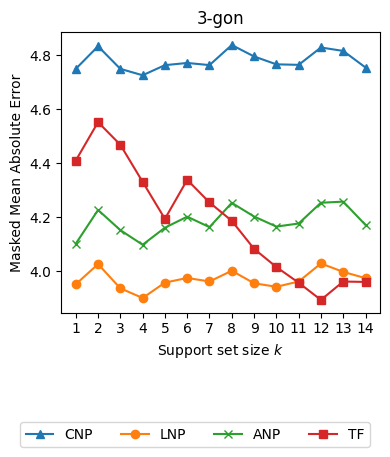


############################################################
Testing mask: {'type': 'angle', 'p': 0.4}
############################################################ 

→ 3-sided polygons


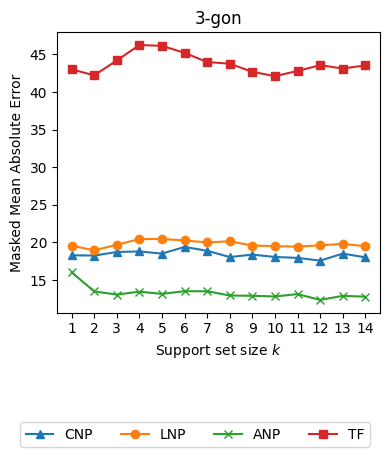


############################################################
Testing mask: {'type': 'vertex', 'p': 0.2}
############################################################ 

→ 3-sided polygons


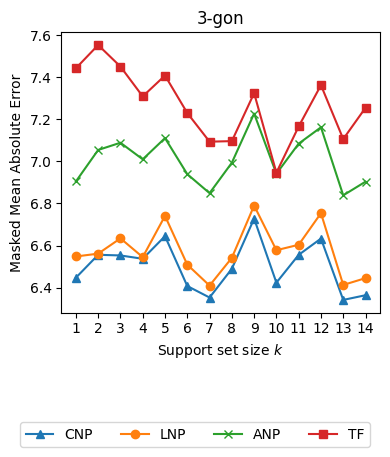


############################################################
Testing mask: {'type': 'random', 'p': 0.15}
############################################################ 

→ 3-sided polygons


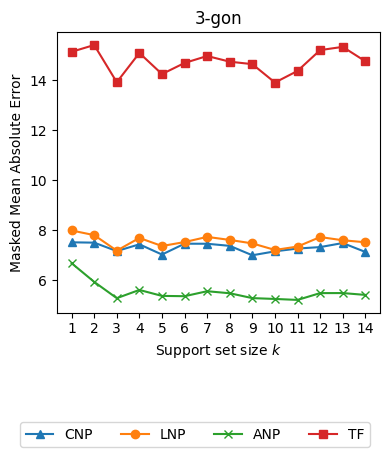

Saved consolidated results to ../figures/all_context_sensitivity_results_random.csv


In [8]:
sides = range(3,4)
context_sizes = list(range(1, 15))
runs_per_size = 10
tf_max_seq_len = 512

mask_configs = [
    {"type": "length", "p": 0.4},
    {"type": "angle", "p": 0.4},
    {"type": "vertex", "p": 0.2},  # only mask vertex tokens
    {"type": "random", "p": 0.15},
]

all_rows = []

for mask_cfg in mask_configs:
    print("\n" + "#"*60)
    print("Testing mask:", mask_cfg)
    print("#"*60, "\n")

    results = {s : {} for s in sides}

    for s in sides:
        print(f"→ {s}-sided polygons")
        # make a reader that only generates s-sided polygons, with deterministic masks
        polygon_reader_eval = PolygonSentenceReader(
            batch_size=128,
            max_num_context=MAX_CONTEXT_POINTS,
            max_seq_len=x_size,
            min_num_sides=s,
            max_num_sides=s,
            center=(12,12),
            radius=6,
            testing=True,
        )

        masked_mae, masked_mae_std = compare_models_shared_data(
            reader=polygon_reader_eval,
            cnp_model=cnp_model,
            np_model=np_model,
            anp_model=anp_model,
            tf_model=tf_model,
            tf_max_seq_len=tf_max_seq_len,
            context_sizes=context_sizes,
            runs_per_size=runs_per_size,
            mask_cfg=mask_cfg,
            device=device
        )

        results[s]["masked_mae"], results[s]["masked_mae_std"] = masked_mae, masked_mae_std

        for model_name in ['CNP','LNP','ANP','TF']:
            for k in context_sizes:
                m  = results[s]['masked_mae'][model_name][k]["masked_mae"]
                sd = results[s]['masked_mae_std'][ model_name][k]["masked_mae"]
                all_rows.append({
                    'mask_type':   mask_cfg['type'],
                    'mask_p':      mask_cfg.get('p', '0'),
                    'side_count':  s,
                    'model':       model_name,
                    'k':           k,
                    'mae_mean':    m,
                    'mae_std':     sd
                })

    plot_configs = [
        ('abs_err',    'Average Absolute Error'),
        ('masked_mae', 'Masked MAE'),
        ('sum_err',    'Masked Sum Error'),
    ]
    model_plotting = [
        ('CNP', '-^'),
        ('LNP',  '-o'),
        ('ANP', '-x'),
        ('TF',  '-s'),
    ]

    ncols = len(sides)
    fig, ax = plt.subplots(
        1, ncols,
        sharey=True,
        figsize=(4 * ncols, 4)
    )

    for s in sides:
        for model_name, marker in model_plotting:
            ys   = [results[s]['masked_mae'][model_name][k]["masked_mae"] for k in context_sizes]
            yerr = [results[s]['masked_mae_std'][model_name][k]["masked_mae"] for k in context_sizes]
            ax.plot(
                context_sizes, ys,
                marker,
                label=model_name,
            )
        ax.set_title(f"{s}-gon")
        ax.set_xlabel("Support set size $k$")
        ax.set_xticks(context_sizes)

    ax.set_ylabel("Masked Mean Absolute Error")

    # one legend for all
    fig.legend(
        [m for m,_ in model_plotting],
        loc='upper center',
        ncol=len(model_plotting),
        bbox_to_anchor=(0.5, -0.05)
    )

    fig.tight_layout(rect=[0,0.05,1,1])
    # if mask_cfg['type'] == "random":
    #     fig.savefig(f"../figures/context_sensitivity_{mask_cfg['type']}{mask_cfg.get('p', '')}.pdf",
    #                 bbox_inches='tight',)
    # else:
    fig.savefig(f"../notebooks/polygon/masked_completion_task/figures/context_sensitivity_{mask_cfg['type']}{mask_cfg.get('p', '')}.pdf")
    plt.show()

df = pd.DataFrame(all_rows)
df.to_csv('../notebooks/polygon/masked_completion_task/figures/all_context_sensitivity_results_random.csv', index=False)
print(f"Saved consolidated results to ../notebooks/polygon/masked_completion_task/figures/all_context_sensitivity_results_random.csv")


############################################################
Testing mask: {'type': 'length'}
############################################################ 

→ 5-sided polygons


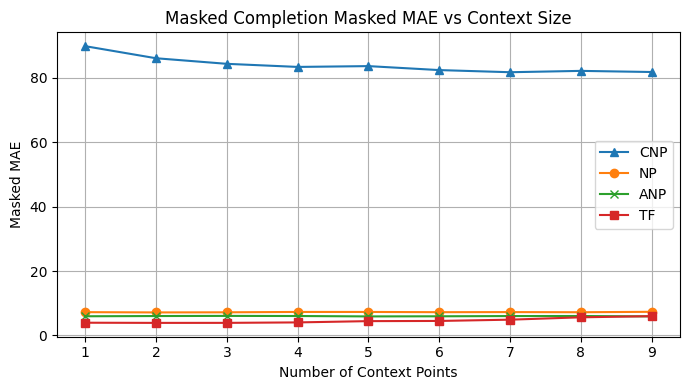


############################################################
Testing mask: {'type': 'length', 'p': 0.2}
############################################################ 

→ 5-sided polygons


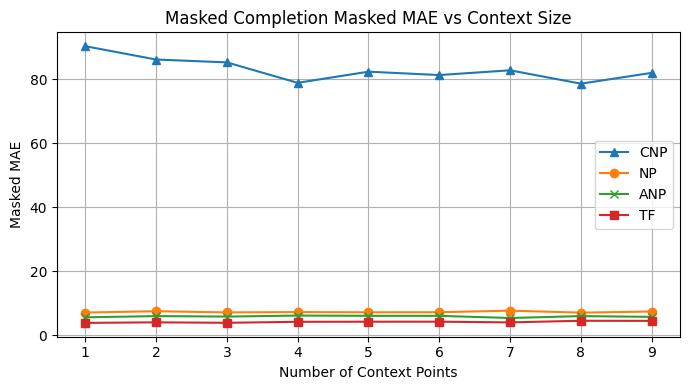


############################################################
Testing mask: {'type': 'angle'}
############################################################ 

→ 5-sided polygons


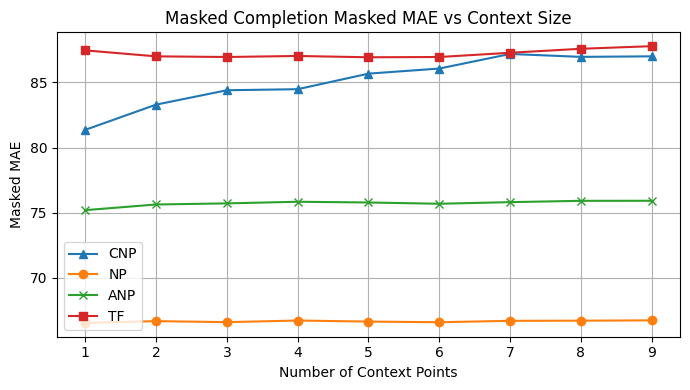


############################################################
Testing mask: {'type': 'angle', 'p': 0.2}
############################################################ 

→ 5-sided polygons


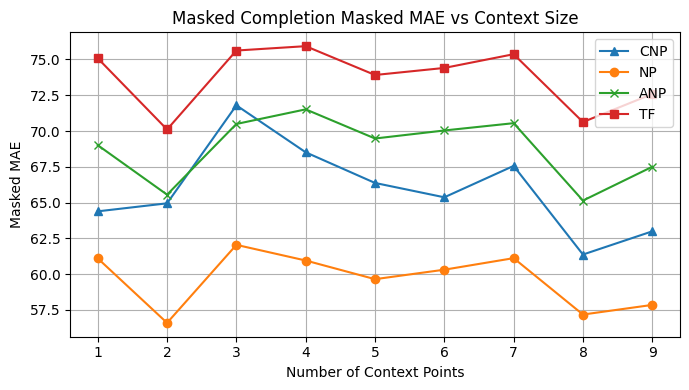


############################################################
Testing mask: {'type': 'vertex', 'p': 0.2}
############################################################ 

→ 5-sided polygons


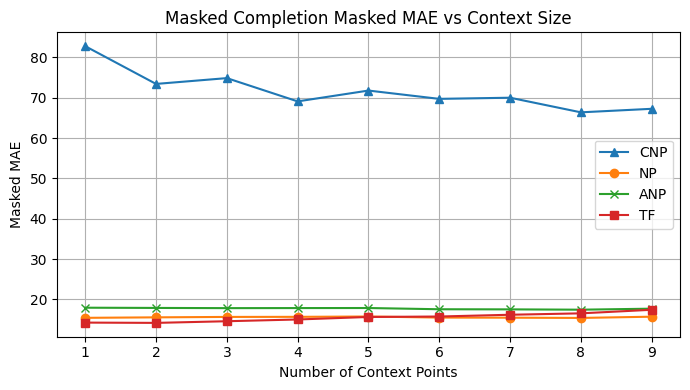


############################################################
Testing mask: {'type': 'random', 'p': 0.15}
############################################################ 

→ 5-sided polygons


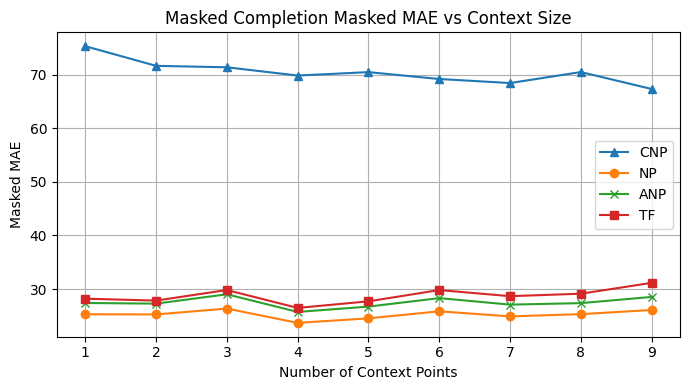


############################################################
Testing mask: {'type': 'random', 'p': 0.3}
############################################################ 

→ 5-sided polygons


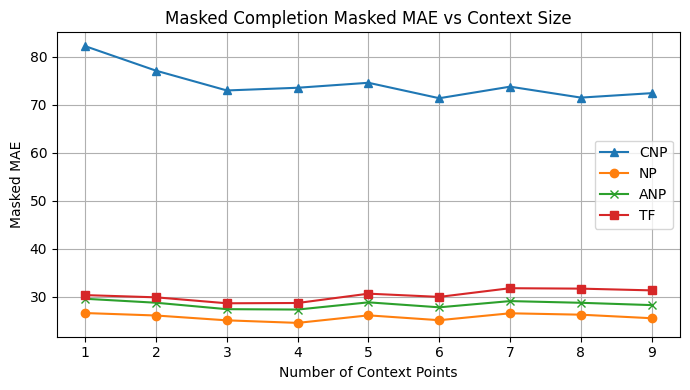

In [ ]:
sides = range(5,6)
context_sizes = list(range(1, 10))
runs_per_size = 3
tf_max_seq_len = 512

mask_configs = [
    {"type": "length"},        # only mask side‐length tokens
    {"type": "length", "p": 0.2},
    {"type": "angle"},         # only mask angle tokens
    {"type": "angle", "p": 0.2},
    {"type": "vertex", "p": 0.2},  # only mask vertex tokens
    {"type": "random", "p": 0.15},
    {"type": "random", "p": 0.30},
]

for mask_cfg in mask_configs:
    print("\n" + "#"*60)
    print("Testing mask:", mask_cfg)
    print("#"*60, "\n")

    for s in sides:
        print(f"→ {s}-sided polygons")
        # make a reader that only generates s-sided polygons, with deterministic masks
        polygon_reader_eval = PolygonSentenceReader(
            batch_size=128,
            max_num_context=MAX_CONTEXT_POINTS,
            max_seq_len=x_size,
            radius=7,
            center=(20,20),
            min_num_sides=s,
            max_num_sides=s,
            testing=True,
        )

        compare_models_shared_data(
            reader=polygon_reader_eval,
            cnp_model=cnp_model,
            np_model=np_model,
            anp_model=anp_model,
            tf_model=tf_model,
            tf_max_seq_len=tf_max_seq_len,
            context_sizes=context_sizes,
            runs_per_size=runs_per_size,
            mask_cfg=mask_cfg,
            device=device
        )